# Задание

В данном задании я попробую сравнить качество претрейн моделей и их ансамблей для семантической сегментации класса "машина" и сравнить их качество на подвыборке из датасета cityscapes (датасет приложен к заданию).

- Нужно найти 2-3 любых предобученных модели семантической сегментации, которые можно использовать для сегментации класса "машина"
- Используя предоставленный датасет, нужно посчитать качество этих моделей по отдельности
- Затем нужно агрегировать их предсказания в различных сочитаениях и посчитать качество
- Результатом задачи будет сравнение качества работы ансамблей и отдельных моделей на датасете cityscapes.

> Важно: ансамбль не всегда дает лучшее качество. Целью задания является сравнение качества и поиск лучшего метода использования предобученных моделей, а не улучшение качества за счет ансамбля.

Датасет представляет из себя подвыборку датасета [cityscapes leftImg8bit_trainvaltest.zip](https://www.cityscapes-dataset.com/downloads/), содержащий только класс машина (id=26).

# Дикслеймер

В данном ноутбуке я впервые попробовал поработать с библиотекой mmsegmentation. Изначально выбор пал на нее, так как у нее довольно обширный и современный model zoo, а также в документации обещали легкую кастомизацию под собственные нужды, наивную интеграцию c Сityscapes, готовый инструмент для валидации предобученных моделей и даже для ансамблирования моделей. Как будто то что нужно для этого задания!

Далеко не все из этого оказалось правдой, и очень много времени я потратил на исправления в зависимостях библиотек, дебаг работы самой mmsegmentation, чтение кода разных версий библиотеки. В итоге от многих планов пришлось отказаться. Если бы я знал, что оно так будет, я бы выбрал другой инструмент для подгрузки предобученных моделей :) 

Пишу это как предупреждение, что код ниже может быть не оптимальным как с точки зрения работы с mmsegmentation, так и вне зависимости от факта ее использования. 

Так как мне задачка показалась интересной и для меня является новой (до этого не работал с семантической сегментацией), решил подойти к ней как к учебному проекту. Я постарался сделать свои действия максимально читаемыми и понятными, возможно в ущерб оптимизации и эффективности некоторых функций. 

Если у вас есть какие-либо замечания или комментарии, буду рад, если вы напишите мне в телеграмме: @jdbelg 

Во втором ноутбуке (Bloopers.ipynb) собраны сниппеты неудачных экспериментов с библиотекой mmseg. Если в двух словах, изначально я хотел прогонять итоговые модели на метриках cityscapes. Также хотел сравнить готовые предобученные модели с файн-тюнинг версиями на текущей подвыборке. К сожалению, обе затеи пока не осуществились, но я планирую к ним вернуться, когда будет время. Если кто-то сможет указать мне на мои ошибки, буду очень признателен :)

Использованные материалы:

[ссылка раз](https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics)

[ссылка два](https://github.com/Visceral-Project/EvaluateSegmentation)

[ссылка три](https://mmsegmentation.readthedocs.io/en/latest/)

## Импорт библиотек и изучение датасета

Импорт библиотек

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch, torchvision

import os
import os.path as osp
import glob
import cv2
import matplotlib.pyplot as plt
import sklearn.metrics as skm

import glob
import mmcv
import mmengine

from tqdm import tqdm_notebook
from PIL import Image
from mmseg.apis import init_model, inference_model, show_result_pyplot
from itertools import combinations

Код для очистки видеопамяти

In [150]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [151]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1036 MiB |   3357 MiB | 135275 GiB | 135274 GiB |
|       from large pool |    891 MiB |   3222 MiB | 135243 GiB | 135242 GiB |
|       from small pool |    144 MiB |    144 MiB |     32 GiB |     31 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1036 MiB |   3357 MiB | 135275 GiB | 135274 GiB |
|       from large pool |    891 MiB |   3222 MiB | 135243 GiB |

Посмотрим на датасет

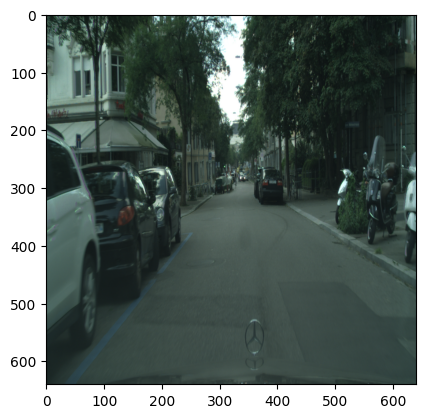

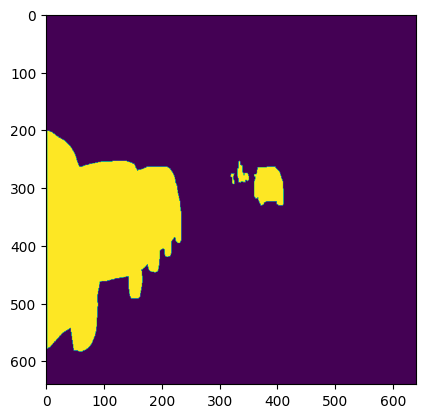

In [152]:
imgs_dir = "task/dataset/imgs"
sem_seg_dir = "task/dataset/gt_sem_seg"

def get_img_and_gt(index):
    img = cv2.imread(os.path.join(imgs_dir, f"{index:06d}.png"))
    sem_seg = cv2.imread(os.path.join(sem_seg_dir, f"{index:06d}.png"), cv2.IMREAD_GRAYSCALE)
    return img, sem_seg

pics = [100,200,400,500]
for img_index in pics:
    img, sem_seg = get_img_and_gt(img_index)

plt.figure()
_ = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.figure()
_ = plt.imshow(sem_seg)

## Функции-помощники

In [4]:
def gt_normilize():
    """"
    Normilizes GT data to [0,1].
    Creates directory with normilized images
    """
    input_path = "task/dataset/gt_sem_seg/*"
    output_path = "task/dataset/gt_sem_seg_1/"

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    images = glob.glob(input_path)

    for pic in tqdm_notebook(images):
        img = mmcv.imread(pic)
        result_pic = (img == 255) * 1
        cv2.imwrite(str(output_path+pic[-10:]), result_pic)
    
# gt_normilize()

In [5]:
def result_saver(model, model_name):
    """"
    Makes prediction with one model.
    Creates directory with predicted masks.

    Input:
    model (MMSEG Module.type of EncoderDecoder): loaded model
    model_name (str): name of output directory with predicted masks

    Output:
    str: Success
    """

    prefix_path = "task/dataset/" 
    input_path = prefix_path + "imgs/*"
    output_path = prefix_path + model_name + "/"

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    images = glob.glob(input_path)

    for pic in tqdm_notebook(images):
        img = mmcv.imread(pic)
        result = inference_model(model, img)
        mask = (result.pred_sem_seg.data == 13).type(torch.uint8) 
        result_pic = mask.cpu().numpy()[0] * 1
        cv2.imwrite(str(output_path+pic[-10:]), result_pic)

    return "Success"

In [6]:
def precision_score_(groundtruth_mask, pred_mask):
    """"
    Counts precision score for one prediction image

    Input:
    groundtruth_mask (np.array): GT mask
    pred_mask (np.array): prediction mask

    Output:
    precision (float): precision score
    """
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    if total_pixel_pred == 0:
        total_pixel_pred += 0.0001
    precision = np.mean(intersect/total_pixel_pred)

    return precision


def recall_score_(groundtruth_mask, pred_mask):
    """"
    Counts recall score for one prediction image

    Input:
    groundtruth_mask (np.array): GT mask
    pred_mask (np.array): prediction mask

    Output:
    recall (float): recall score
    """

    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return recall


def accuracy(groundtruth_mask, pred_mask):
    """"
    Counts accuracy score for one prediction image

    Input:
    groundtruth_mask (np.array): GT mask
    pred_mask (np.array): prediction mask

    Output:
    accuracy (float): accuracy score
    """

    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return acc

def dice_coef(groundtruth_mask, pred_mask):
    """"
    Counts DICE (F1) score for one prediction image

    Input:
    groundtruth_mask (np.array): GT mask
    pred_mask (np.array): prediction mask

    Output:
    dice (float): DICE (F1) score
    """

    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return dice


def iou(groundtruth_mask, pred_mask):
    """"
    Counts iou (Jaccard) score for one prediction image

    Input:
    groundtruth_mask (np.array): GT mask
    pred_mask (np.array): prediction mask

    Output:
    iou (float): iou (Jaccard) score
    """

    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return iou

In [7]:
def grid_imshow(mask):
    """"
    Plots pretty grid for visual comfort

    Input:
    mask (np.array): GT or prediction image

    Output:
    Gridlines based on major ticks
    """

    ax = plt.gca()
    plt.imshow(mask, cmap="gray" if len(mask.shape)==2 else None, 
               interpolation="none", vmin=0, vmax=1, aspect="equal")
    
    if mask.shape[1] < 20:
        # Major ticks
        ax.set_xticks(np.arange(0, mask.shape[1], 1))
        ax.set_yticks(np.arange(0, mask.shape[0], 1))

        # Labels for major ticks
        ax.set_xticklabels(np.arange(1, mask.shape[1]+1, 1))
        ax.set_yticklabels(np.arange(1, mask.shape[0]+1, 1))

        # Minor ticks
        ax.set_xticks(np.arange(-.5, mask.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-.5, mask.shape[0], 1), minor=True)
        
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='blue', linestyle='-', linewidth=2)

    else:
        # Major ticks
        ax.set_xticks(np.arange(0, mask.shape[1], 100))
        ax.set_yticks(np.arange(0, mask.shape[0], 100))

        # Labels for major ticks
        ax.set_xticklabels(np.arange(0, mask.shape[1], 100))
        ax.set_yticklabels(np.arange(0, mask.shape[0], 100))

        # Gridlines based on major ticks
        ax.grid(which='major', color='blue', linestyle='-', linewidth=2)


def compare_masks(gt_mask, pred_mask, gt_title="Ground Truth Mask", 
                  pred_title="Prediction Mask", _figshape=(10,10)):
    """"
    Plots GT and predictions masks next to each other
    """

    plt.figure(figsize=_figshape)

    plt.subplot(1,2,1)    
    grid_imshow(gt_mask)
    plt.title(gt_title, fontweight="bold")

    plt.subplot(1,2,2)
    grid_imshow(pred_mask * 255)
    plt.title(pred_title, fontweight="bold")

    plt.tight_layout()
    plt.show()

def metrics_table(gt_masks, pred_masks):
    """"
    Counts all metrics

    Input:
    gt_masks List(np.array): GT masks
    pred_masksList(np.array): prediction masks


    Output:
    df (pd.dataframe): dataframe with all metrics for one image

    """

    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    for _, (mask, pred) in enumerate(zip(gt_masks, pred_masks)):
        metrics['Precision'].append(precision_score_(mask, pred))
        metrics['Recall'].append(recall_score_(mask, pred))
        metrics['Accuracy'].append(accuracy(mask, pred))
        metrics['Dice'].append(dice_coef(mask, pred))
        metrics['IoU'].append(iou(mask, pred))
    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df

## Индивидуальные результаты моделей

### PSP (default for mmseg)

![Архитектура модели](pictures/142902444-9f93b99e-9261-443b-a0a4-17e78eefb525.png)

Инициализируем модель

In [8]:
psp_config_file = 'models/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py'
psp_checkpoint_file = 'models/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
psp_model = init_model(psp_config_file, psp_checkpoint_file, 'cuda:0')
model_name = "pspnet_default"

result_saver(psp_model, model_name)

Loads checkpoint by local backend from path: models/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


  0%|          | 0/3311 [00:00<?, ?it/s]

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


'Success'

Смотрим на предсказания

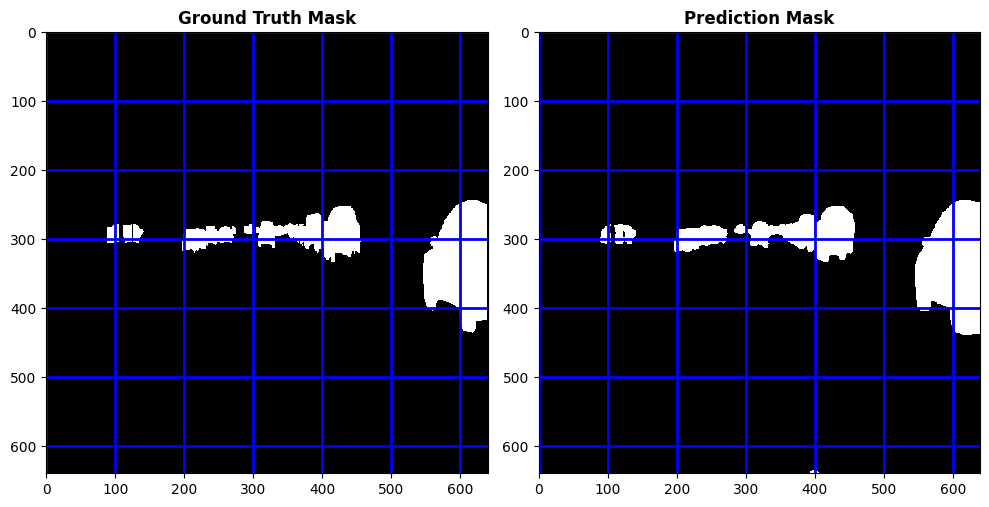

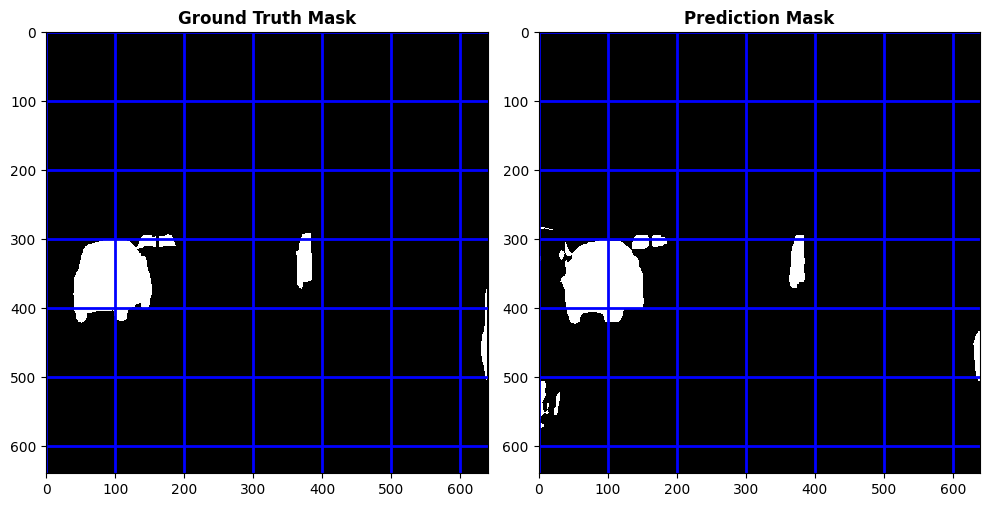

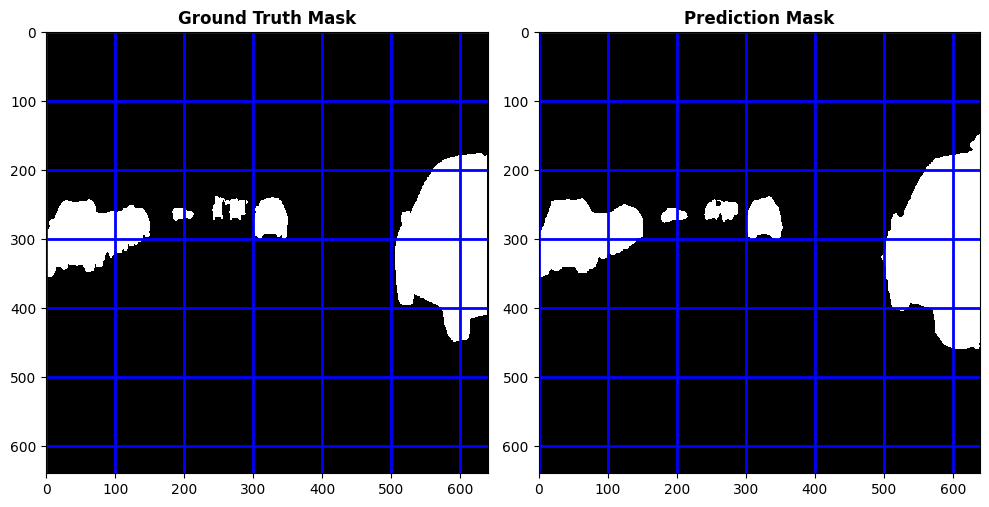

In [158]:
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000017.png"), mmcv.imread("task/dataset/pspnet_default/000017.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000100.png"), mmcv.imread("task/dataset/pspnet_default/000100.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000234.png"), mmcv.imread("task/dataset/pspnet_default/000234.png"))

Считаем метрики

In [159]:
inputs = [mmcv.imread(file) for file in glob.glob("task/dataset/gt_sem_seg_1/*.png")]
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/pspnet_default/*.png")]

In [160]:
psp_results = metrics_table(inputs, labels)

In [161]:
psp_results.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.881163,0.917792,0.992891,0.894199,0.831151
std,0.139694,0.163592,0.008160,0.151164,0.168410
min,0.000000,0.000000,0.796326,0.000000,0.000000
25%,0.878805,0.927425,0.990546,0.896817,0.812936
50%,0.918812,0.974276,0.995015,0.941056,0.888673
75%,0.940905,0.989916,0.997594,0.960364,0.923750
max,1.000000,1.000000,0.999910,0.988074,0.976429


**Здесь и далее нас в первую очередь интересуют средние значения Dice и IoU.**

Accuracy при таком сильном дизбалансе классов сама по себе не является полезной метрикой (сильно завышает качество), но может принести пользу в интерпретации моделей косвенно.

Видим, что у некоторых объектов все метрики, кроме Accuracy равны нулю. Такое может быть, если в confusion matrix TP и TN равны нулю. В нашем случае это скорее всего означает, что класса машины на предсказании просто не оказалось - пересечения с GT нет. Посмотрим, сколько таких объектов в случае использования PSP

In [162]:
strange_psp = psp_results[psp_results['Precision'] == 0]
print(f'PSP имеет неадекватные метрики на {strange_psp.count()[0]} картинках. Вот первые три:')
strange_psp.head(3)

PSP имеет неадекватные метрики на 46 картинках. Вот первые три:


,Precision,Recall,Accuracy,Dice,IoU
19,0.0,0.0,0.998376,0.0,0.0
146,0.0,0.0,0.999785,0.0,0.0
163,0.0,0.0,0.999558,0.0,0.0


Посмотрим на изображения, в которых получились такие выбросы

task/dataset/gt_sem_seg_1/000401.png
task/dataset/gt_sem_seg_1/001656.png
task/dataset/gt_sem_seg_1/000341.png


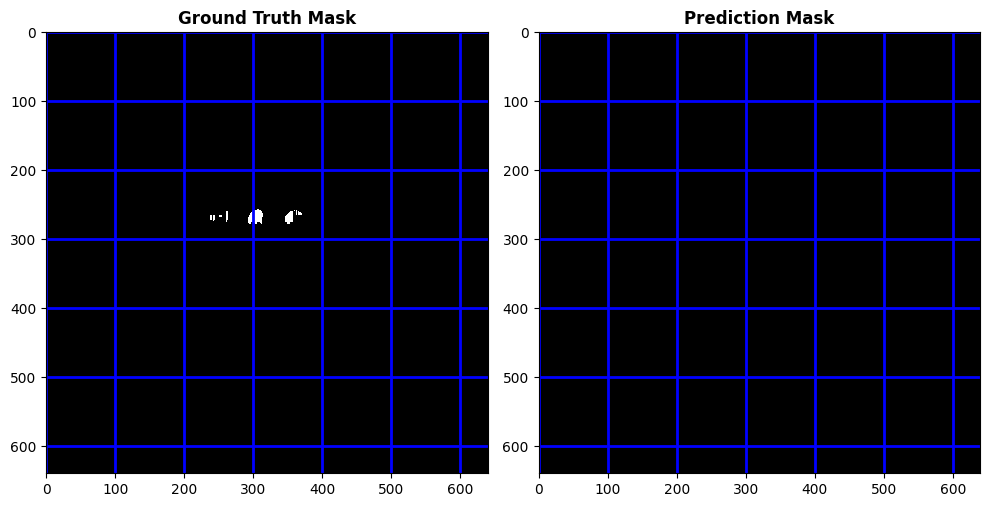

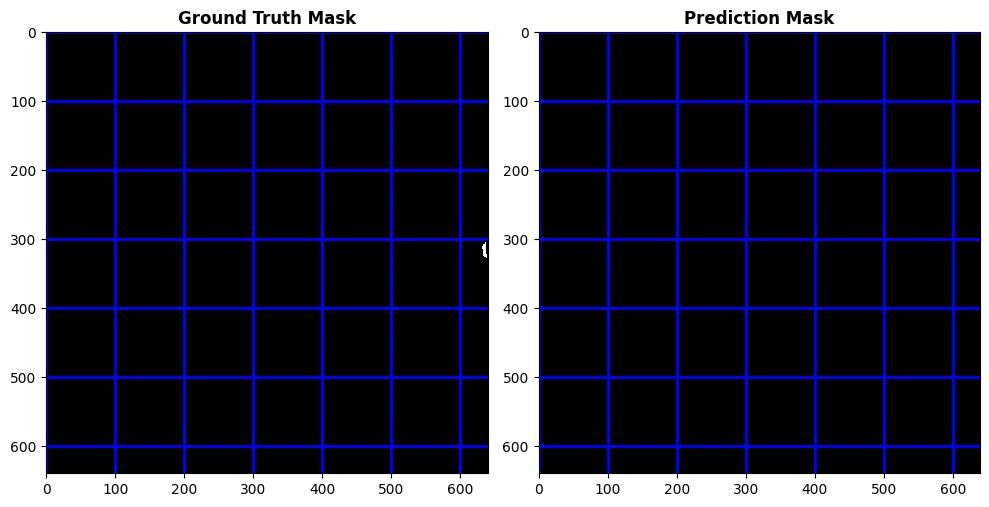

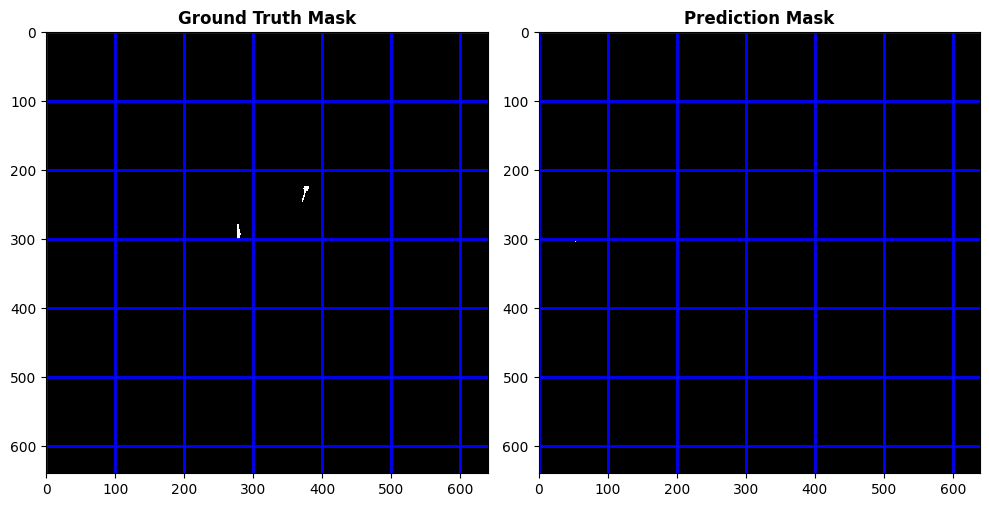

In [163]:
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[19])
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[146])
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[163])

compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000401.png"), mmcv.imread("task/dataset/pspnet_default/000401.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/001656.png"), mmcv.imread("task/dataset/pspnet_default/001656.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000341.png"), mmcv.imread("task/dataset/pspnet_default/000341.png"))

Действительно, на этих изображениях практически отсутствует класс машина даже на GT. Для меня оказалось спорным решением оставлять такие примеры при подсчете метрик. Но и просто так выбрасывать их неправильно. Поэтому я решил для каждой последующей итерации, будь то прогон отдельной модели или ансамбля, считать метрики с учетом таких "выбросов", и без них. 

Забегая вперед, это оказалось неплохим решением: у разных моделей получилось разное количество "выбросов", наверное на практике это в каком-то случае тоже может быть метрикой при выборе той или иной модели.

Метрики без выбросов

In [164]:
psp_results_clean = psp_results[psp_results['Dice'] != 0]
psp_results_clean.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3265.000000,3265.000000,3265.000000,3265.000000,3265.000000
mean,0.893578,0.930722,0.992802,0.906797,0.842861
std,0.093234,0.122886,0.008181,0.108375,0.137437
min,0.007353,0.002232,0.796326,0.003425,0.001715
25%,0.881535,0.932161,0.990481,0.901449,0.820580
50%,0.919578,0.975138,0.994934,0.941637,0.889711
75%,0.941152,0.990091,0.997515,0.960485,0.923974
max,1.000000,1.000000,0.999907,0.988074,0.976429


### UNET

![Архитектура модели](pictures/142902977-20fe689d-a147-4d92-9690-dbfde8b68dbe.png)

Далее алгоритм аналогичен тому, что было выше. Не буду повторно описывать :)

In [9]:
unet_config_file = 'mmsegmentation/configs/unet/unet-s5-d16_fcn_4xb4-160k_cityscapes-512x1024.py'
unet_checkpoint_file = 'models/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes_20211210_145204-6860854e.pth'
unet_model = init_model(unet_config_file, unet_checkpoint_file, 'cuda:0')
model_name = 'unet'

result_saver(unet_model, model_name)

Loads checkpoint by local backend from path: models/fcn_unet_s5-d16_4x4_512x1024_160k_cityscapes_20211210_145204-6860854e.pth


  0%|          | 0/3311 [00:00<?, ?it/s]

'Success'

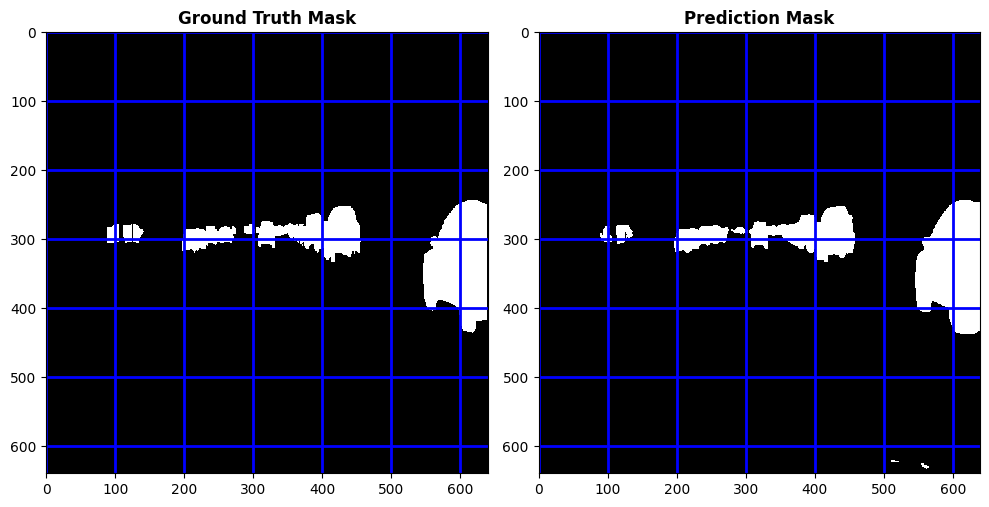

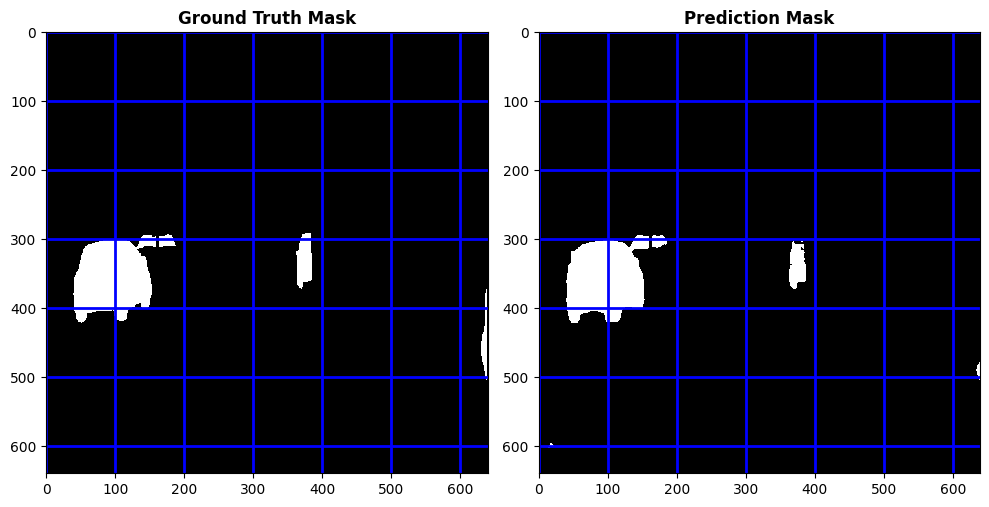

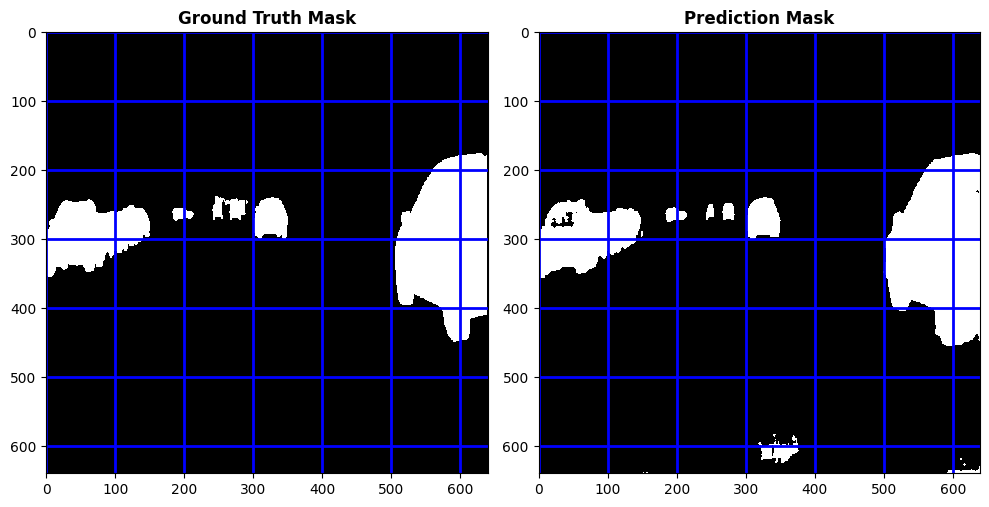

In [166]:
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000017.png"), mmcv.imread("task/dataset/unet/000017.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000100.png"), mmcv.imread("task/dataset/unet/000100.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000234.png"), mmcv.imread("task/dataset/unet/000234.png"))

In [167]:
#inputs = [mmcv.imread(file) for file in glob.glob("task/dataset/gt_sem_seg_1/*.png")]
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/unet/*.png")]

In [168]:
unet_results = metrics_table(inputs, labels)

In [169]:
unet_results.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.823292,0.913716,0.991577,0.856807,0.783852
std,0.204786,0.164884,0.007124,0.190084,0.210689
min,0.000000,0.000000,0.890925,0.000000,0.000000
25%,0.809853,0.923741,0.988636,0.854130,0.745399
50%,0.901595,0.967998,0.993264,0.927699,0.865149
75%,0.939661,0.984980,0.996456,0.956213,0.916100
max,1.000000,1.000000,0.999958,0.986477,0.973316


In [170]:
strange_unet = unet_results[unet_results['Precision'] == 0]
print(f'Unet имеет неадекватные метрики на {strange_unet.count()[0]} картинках. Вот первые три:')
strange_unet.head(3)

Unet имеет неадекватные метрики на 48 картинках. Вот первые три:


,Precision,Recall,Accuracy,Dice,IoU
50,0.0,0.0,0.991396,0.0,0.0
163,0.0,0.0,0.997896,0.0,0.0
226,0.0,0.0,0.999512,0.0,0.0


task/dataset/gt_sem_seg_1/000902.png
task/dataset/gt_sem_seg_1/000341.png
task/dataset/gt_sem_seg_1/002344.png


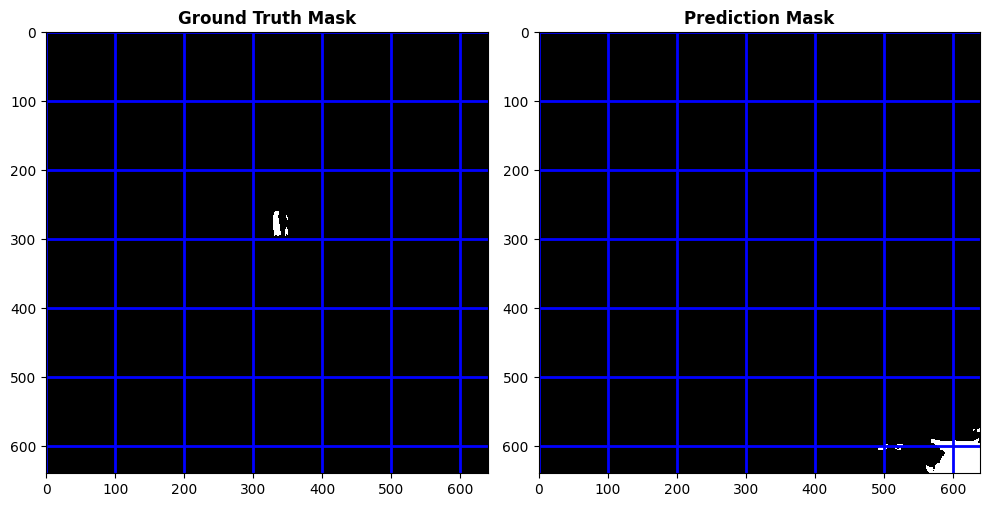

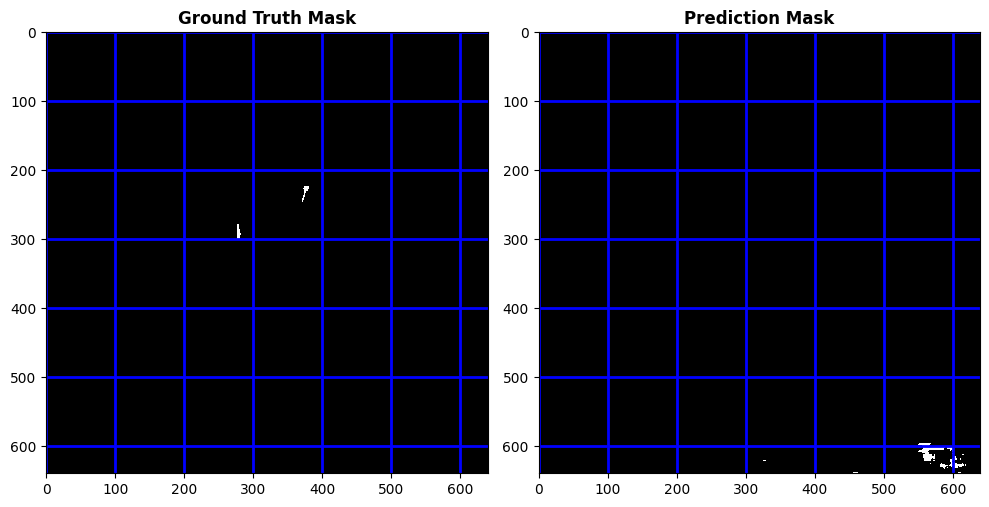

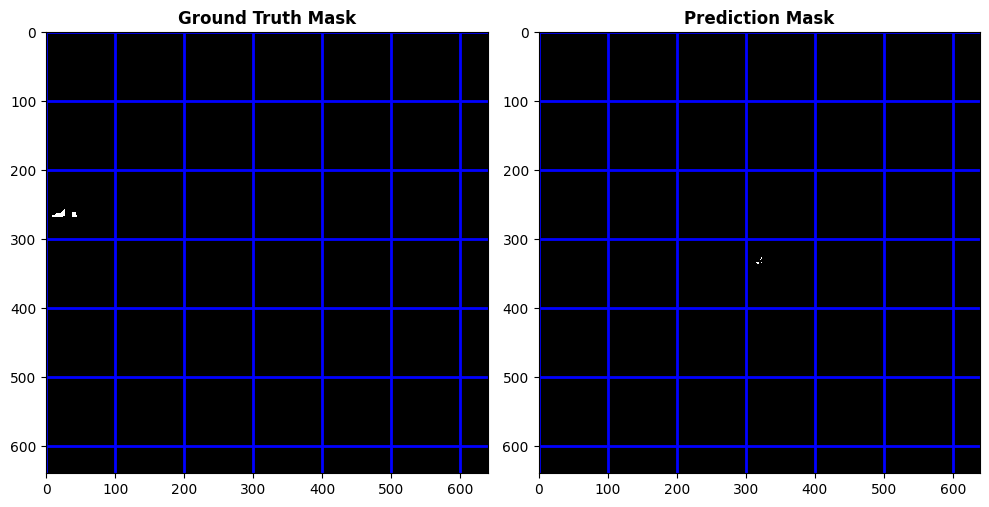

In [171]:
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[50])
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[163])
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[226])

compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000902.png"), mmcv.imread("task/dataset/unet/000902.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000341.png"), mmcv.imread("task/dataset/unet/000341.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/002344.png"), mmcv.imread("task/dataset/unet/002344.png"))

In [172]:
unet_results_clean = unet_results[unet_results['Dice'] != 0]
unet_results_clean.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000
mean,0.835403,0.927158,0.991496,0.869411,0.795383
std,0.180094,0.122968,0.007131,0.160319,0.189391
min,0.000129,0.000524,0.890925,0.000207,0.000103
25%,0.816992,0.927615,0.988611,0.858997,0.752844
50%,0.902797,0.968591,0.993186,0.928539,0.866610
75%,0.940065,0.985154,0.996368,0.956412,0.916466
max,1.000000,1.000000,0.999958,0.986477,0.973316


### FCN

![Архитектура модели](pictures/142901525-fd0d2bf4-9a47-4143-85f5-3cee8849eaa4.png)

In [10]:
fcn_config_file = 'mmsegmentation/configs/fcn/fcn-d6_r101-d16_4xb2-80k_cityscapes-512x1024.py'
fcn_checkpoint_file = 'models/fcn_d6_r101-d16_512x1024_80k_cityscapes_20210308_102747-cb336445.pth'
fcn_model = init_model(fcn_config_file, fcn_checkpoint_file, 'cuda:0')
model_name = 'fcn'

result_saver(fcn_model, model_name)

Loads checkpoint by local backend from path: models/fcn_d6_r101-d16_512x1024_80k_cityscapes_20210308_102747-cb336445.pth


  0%|          | 0/3311 [00:00<?, ?it/s]

'Success'

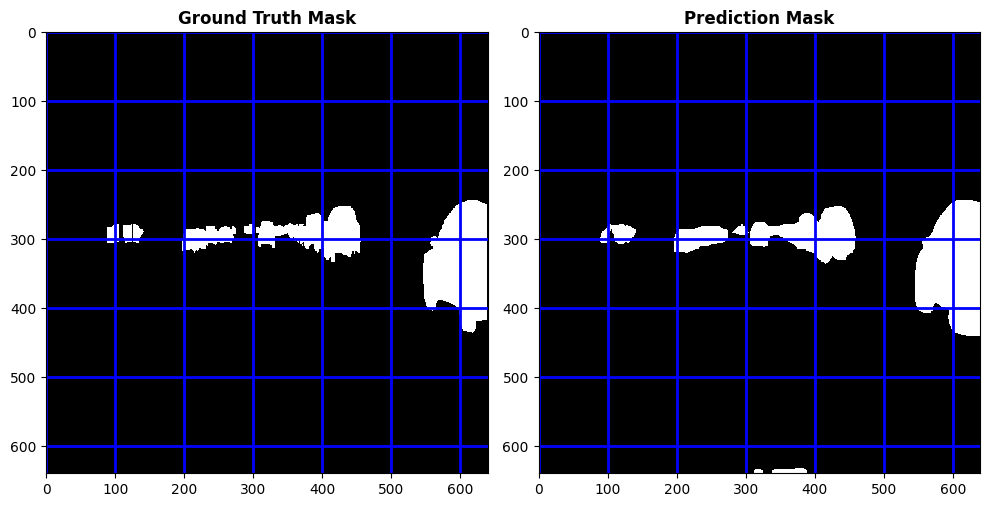

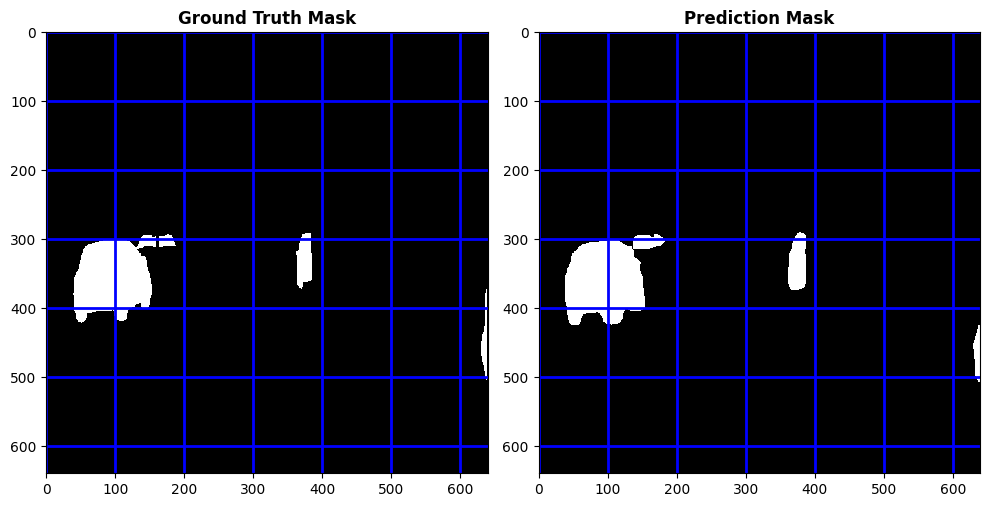

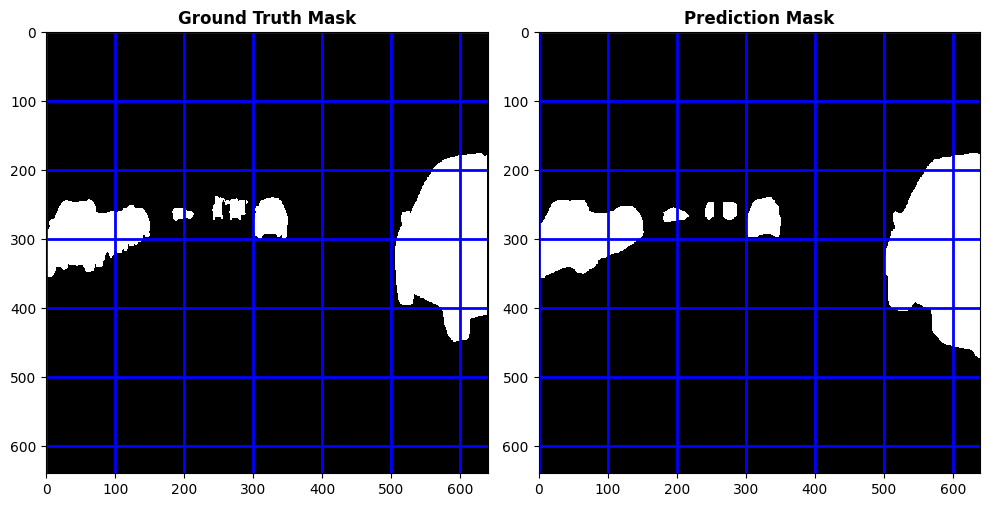

In [174]:
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000017.png"), mmcv.imread("task/dataset/fcn/000017.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000100.png"), mmcv.imread("task/dataset/fcn/000100.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000234.png"), mmcv.imread("task/dataset/fcn/000234.png"))

In [175]:
#inputs = [mmcv.imread(file) for file in glob.glob("task/dataset/gt_sem_seg_1/*.png")]
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/fcn/*.png")]

In [176]:
fcn_results = metrics_table(inputs, labels)

In [177]:
fcn_results.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.882897,0.914593,0.993668,0.893733,0.832794
std,0.147797,0.169952,0.006845,0.160558,0.175534
min,0.000000,0.000000,0.822607,0.000000,0.000000
25%,0.880942,0.925978,0.991595,0.897465,0.814001
50%,0.923791,0.970020,0.995100,0.942496,0.891245
75%,0.946426,0.986701,0.997472,0.963676,0.929898
max,1.000000,0.998880,0.999927,0.988156,0.976590


In [178]:
strange_fcn = fcn_results[fcn_results['Precision'] == 0]
print(f'FCN имеет неадекватные метрики на {strange_fcn.count()[0]} картинках. Вот первые три:')
strange_fcn.head(3)

FCN имеет неадекватные метрики на 60 картинках. Вот первые три:


,Precision,Recall,Accuracy,Dice,IoU
50,0.0,0.0,0.999111,0.0,0.0
138,0.0,0.0,0.998413,0.0,0.0
146,0.0,0.0,0.999785,0.0,0.0


task/dataset/gt_sem_seg_1/000902.png
task/dataset/gt_sem_seg_1/000750.png
task/dataset/gt_sem_seg_1/001656.png


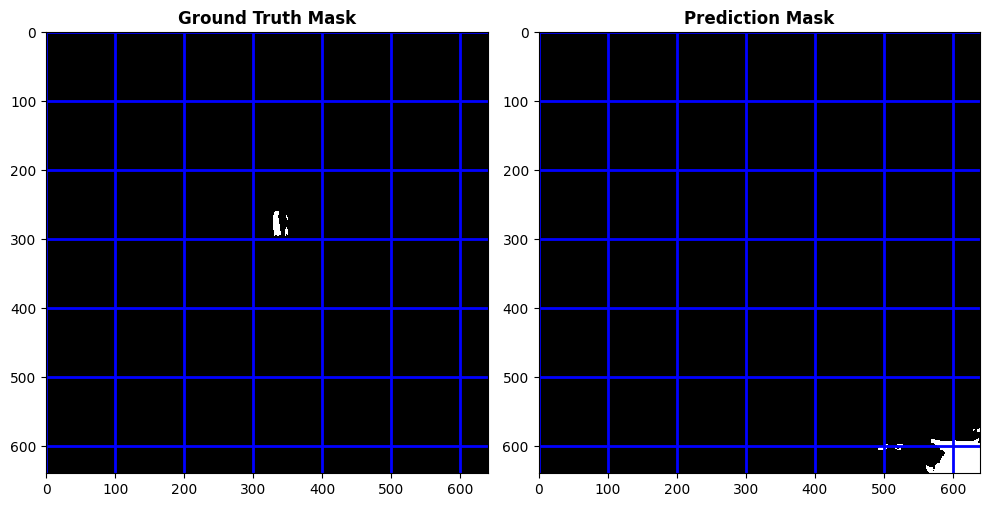

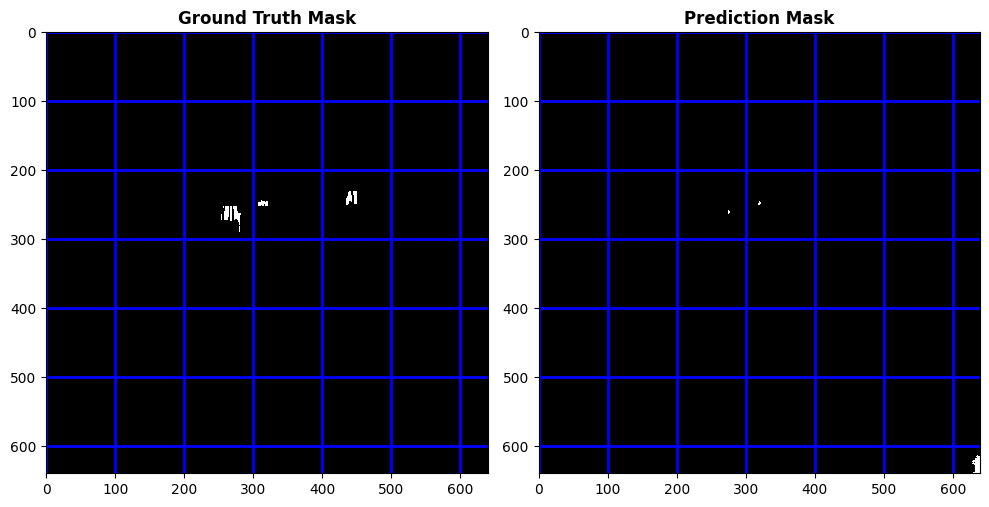

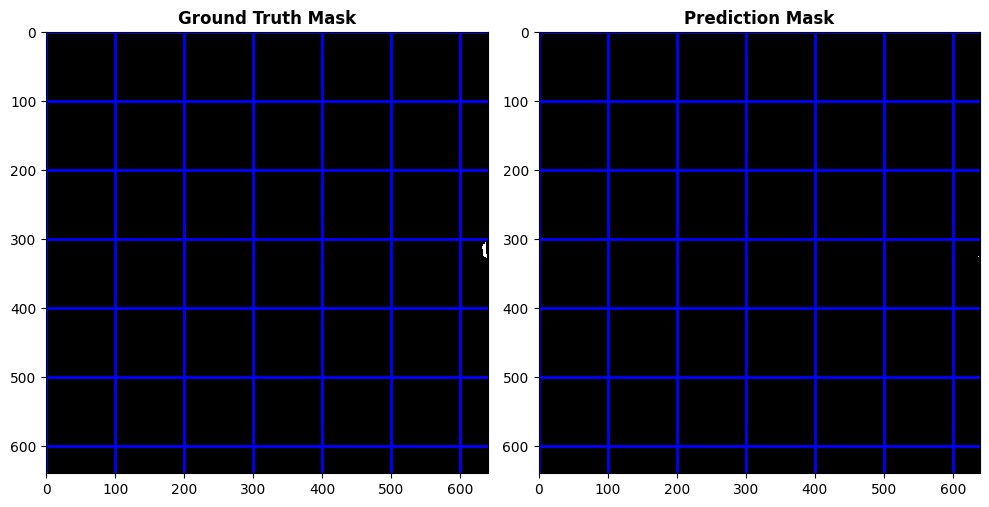

In [179]:
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[50])
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[138])
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[146])

compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000902.png"), mmcv.imread("task/dataset/unet/000902.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000750.png"), mmcv.imread("task/dataset/unet/000750.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/001656.png"), mmcv.imread("task/dataset/unet/001656.png"))

In [180]:
fcn_results_clean = fcn_results[fcn_results['Dice'] != 0]
fcn_results_clean.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3251.000000,3251.000000,3251.000000,3251.000000,3251.000000
mean,0.899191,0.931472,0.993567,0.910227,0.848164
std,0.087125,0.117001,0.006866,0.106001,0.135429
min,0.047899,0.014432,0.822607,0.028136,0.014269
25%,0.884405,0.929461,0.991497,0.902120,0.821693
50%,0.924823,0.971003,0.995034,0.943463,0.892976
75%,0.946850,0.986901,0.997379,0.963862,0.930245
max,1.000000,0.998880,0.999927,0.988156,0.976590


### Deeplabv3+

![Архитектура модели](pictures/142900680-3e2c3098-8341-4760-bbfd-b1d7d29968ea.png)

In [11]:
deeplab_config_file = 'mmsegmentation/configs/deeplabv3plus/deeplabv3plus_r101-d8_4xb2-40k_cityscapes-512x1024.py'
deeplab_checkpoint_file = 'models/deeplabv3plus_r101-d8_512x1024_40k_cityscapes_20200605_094614-3769eecf.pth'
deeplab_model = init_model(deeplab_config_file, deeplab_checkpoint_file, 'cuda:0')
model_name = 'deeplabv3'

result_saver(deeplab_model, model_name)

Loads checkpoint by local backend from path: models/deeplabv3plus_r101-d8_512x1024_40k_cityscapes_20200605_094614-3769eecf.pth


  0%|          | 0/3311 [00:00<?, ?it/s]

'Success'

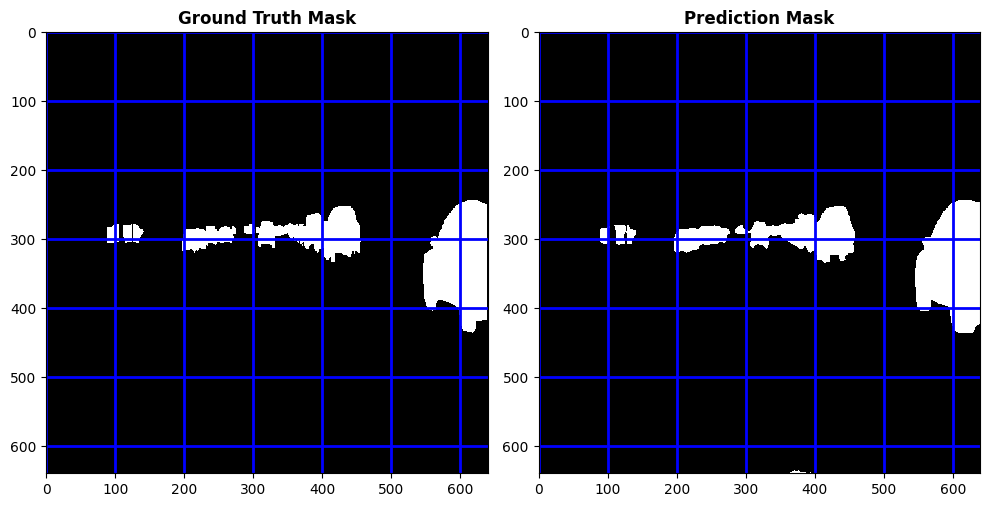

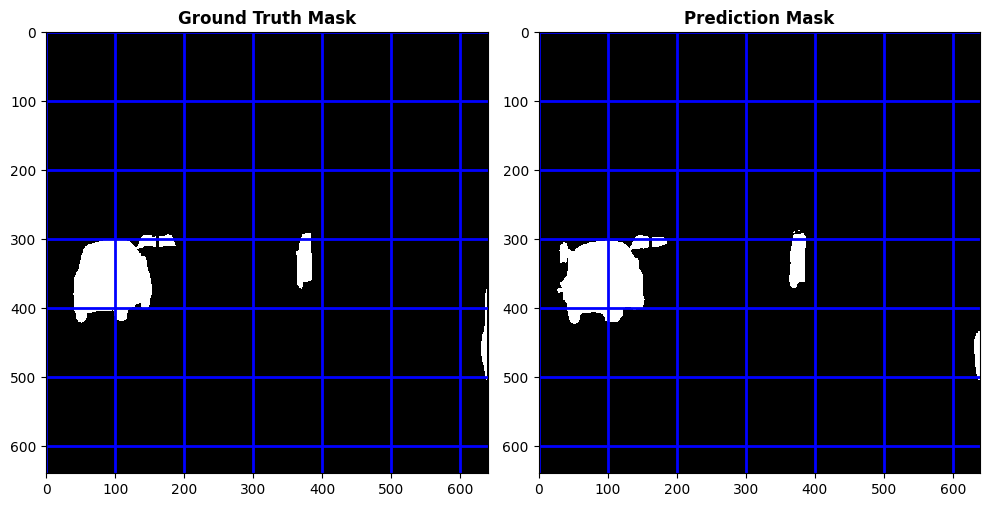

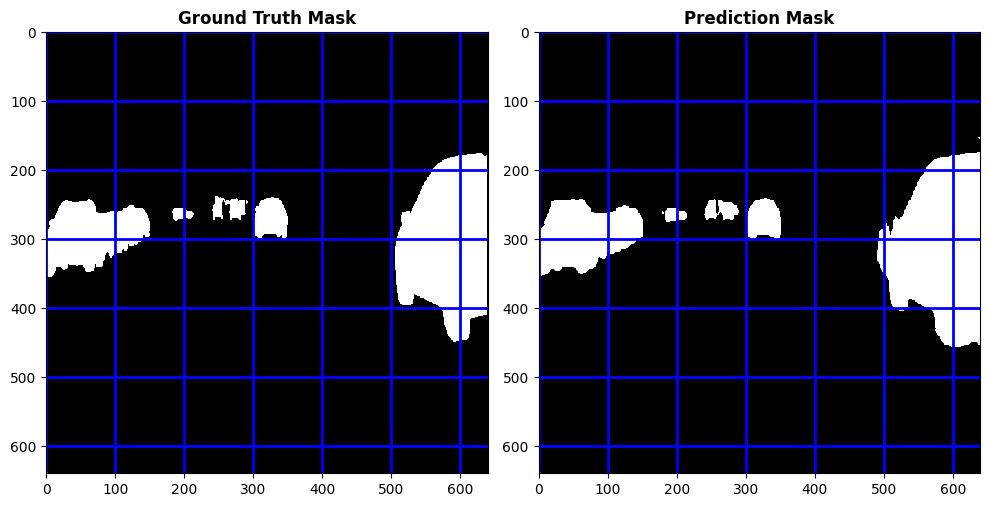

In [182]:
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000017.png"), mmcv.imread("task/dataset/deeplabv3/000017.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000100.png"), mmcv.imread("task/dataset/deeplabv3/000100.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000234.png"), mmcv.imread("task/dataset/deeplabv3/000234.png"))

In [183]:
#inputs = [mmcv.imread(file) for file in glob.glob("task/dataset/gt_sem_seg_1/*.png")]
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/deeplabv3/*.png")]

In [184]:
deeplab_results = metrics_table(inputs, labels)

In [185]:
deeplab_results.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.894739,0.920317,0.994230,0.902868,0.846170
std,0.141808,0.165571,0.006454,0.153996,0.169347
min,0.000000,0.000000,0.817144,0.000000,0.000000
25%,0.893898,0.936337,0.992260,0.910372,0.835489
50%,0.931967,0.974183,0.995640,0.949368,0.903617
75%,0.952029,0.988482,0.997786,0.966972,0.936056
max,1.000000,1.000000,0.999917,0.989609,0.979431


In [186]:
strange_deeplab = deeplab_results[deeplab_results['Precision'] == 0]
print(f'deeplab имеет неадекватные метрики на {strange_deeplab.count()[0]} картинках. Вот первые три:')
strange_deeplab.head(3)

deeplab имеет неадекватные метрики на 57 картинках. Вот первые три:


,Precision,Recall,Accuracy,Dice,IoU
19,0.0,0.0,0.998376,0.0,0.0
50,0.0,0.0,0.999116,0.0,0.0
146,0.0,0.0,0.999785,0.0,0.0


task/dataset/gt_sem_seg_1/000401.png
task/dataset/gt_sem_seg_1/000902.png
task/dataset/gt_sem_seg_1/001656.png


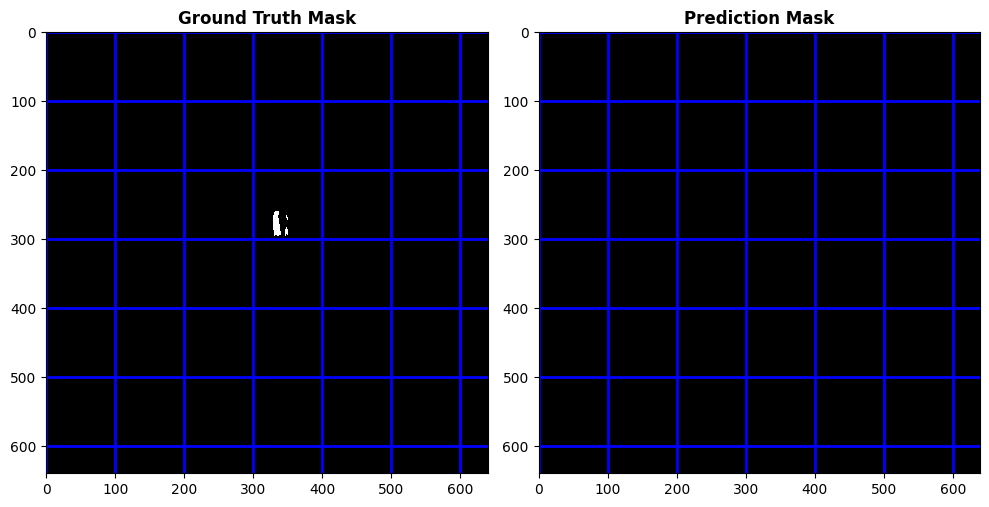

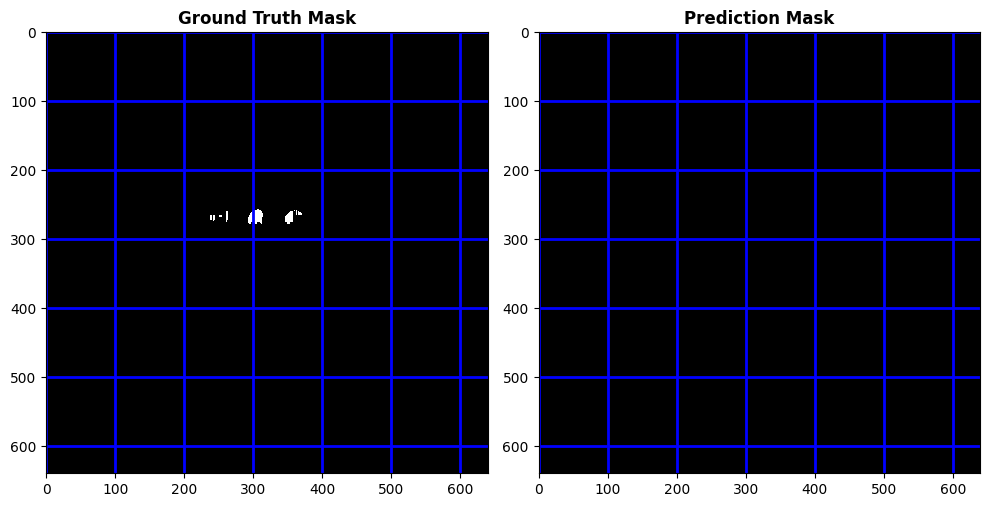

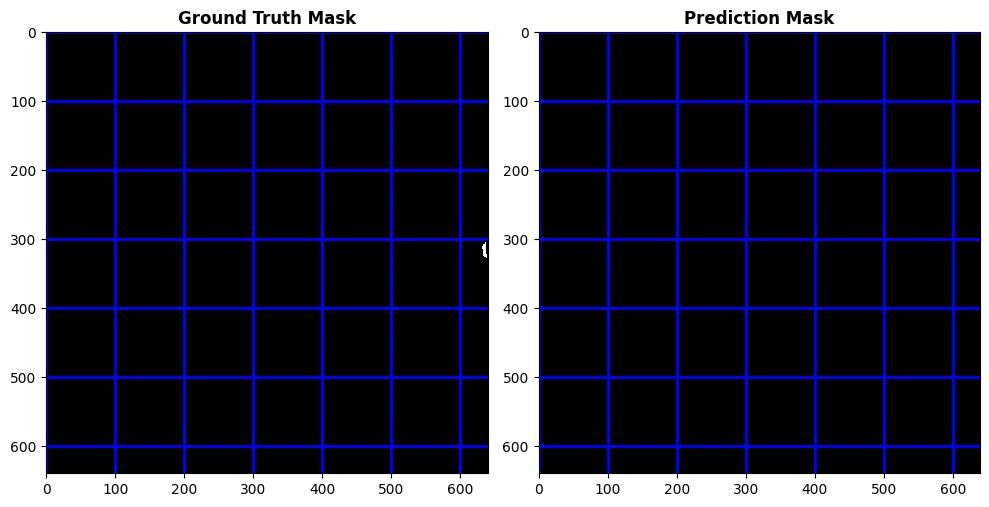

In [187]:
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[19])
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[50])
print(glob.glob("task/dataset/gt_sem_seg_1/*.png")[146])

compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000902.png"), mmcv.imread("task/dataset/deeplabv3/000902.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000401.png"), mmcv.imread("task/dataset/deeplabv3/000401.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/001656.png"), mmcv.imread("task/dataset/deeplabv3/001656.png"))

In [101]:
deeplab_results_clean = deeplab_results[deeplab_results['Dice'] != 0]
deeplab_results_clean.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3254.000000,3254.000000,3254.000000,3254.000000,3254.000000
mean,0.910412,0.936438,0.994143,0.918683,0.860992
std,0.078668,0.113106,0.006475,0.097962,0.128121
min,0.016978,0.013793,0.817144,0.027211,0.013793
25%,0.897162,0.940292,0.992125,0.913983,0.841591
50%,0.932944,0.974907,0.995564,0.950060,0.904871
75%,0.952273,0.988633,0.997703,0.967223,0.936527
max,1.000000,1.000000,0.999907,0.989609,0.979431


Из четырех рассмотренных моделей наилучшее качество показывает Deeplabv3+. 

Но другие модели не особо сильно отстают по качеству, зато могут выигрывать в других моментах. Например, полносвязная модель показывает на удивление хорошие результаты, как по времени, так и по метркикам!

## Ансамблирование моделей

### Пробуем брать среднее от предсказаний нескольких моделей

In [ ]:
def ensemble_result_saver(models, ensemble_name, thr = 0.5):
    prefix_path = "task/dataset/" 
    input_path = prefix_path + "imgs/*"
    output_path = prefix_path + ensemble_name + "/"

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    images = glob.glob(input_path)
    predictions = []

    for pic in tqdm_notebook(images):
        img = mmcv.imread(pic)
        for model in models:
            prediction = inference_model(model, img)
            mask = (prediction.pred_sem_seg.data == 13).type(torch.uint8) 
            predictions.append(mask * 1)
        stack_preds = torch.stack(predictions)
        mean_pred = (torch.mean(stack_preds.float(), dim=0) > thr) * 1
        predictions = []

        cv2.imwrite(str(output_path+pic[-10:]), mean_pred.cpu().numpy()[0])

Попробуем взять среднее от предсказаний всех четырех моделей c порогом 0.5

In [ ]:
model_list = [psp_model, fcn_model, unet_model, deeplab_model]
ensemble_result_saver(model_list, "mean_all_models")

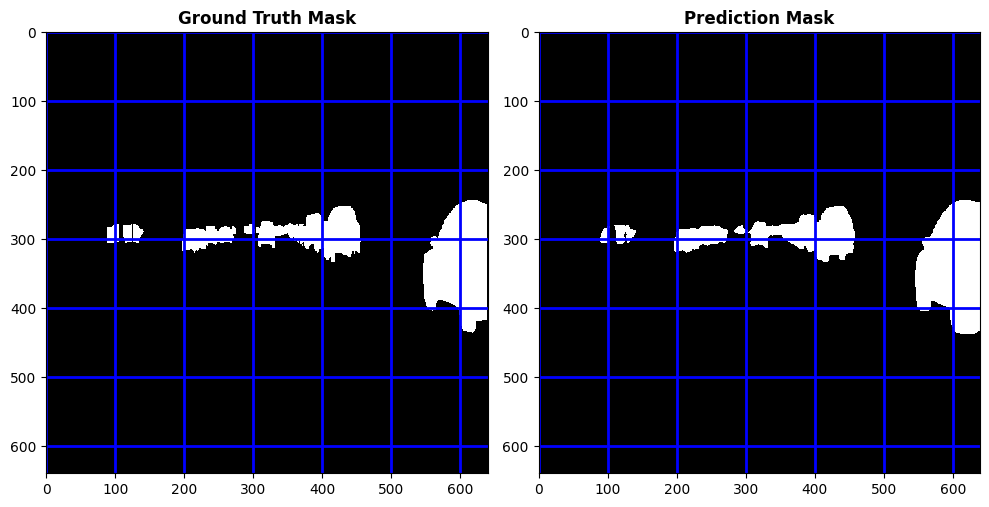

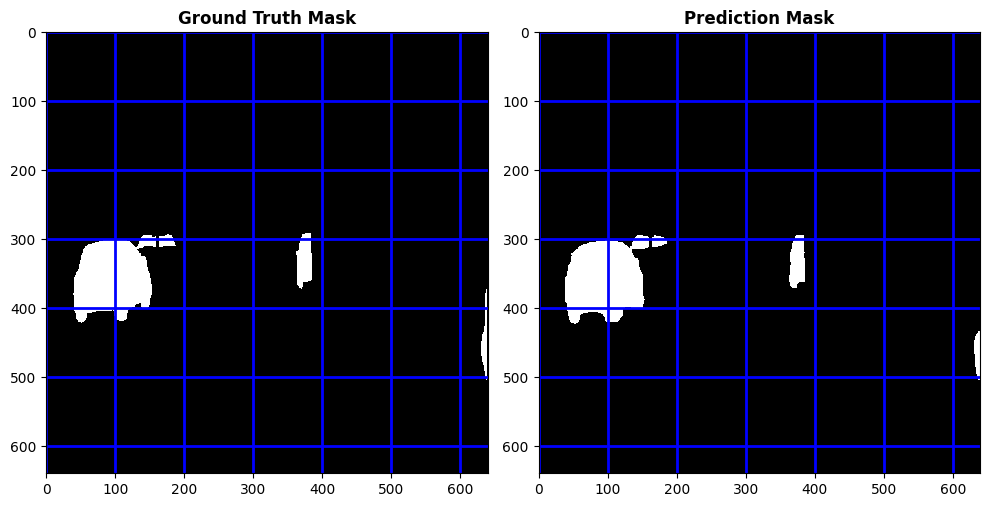

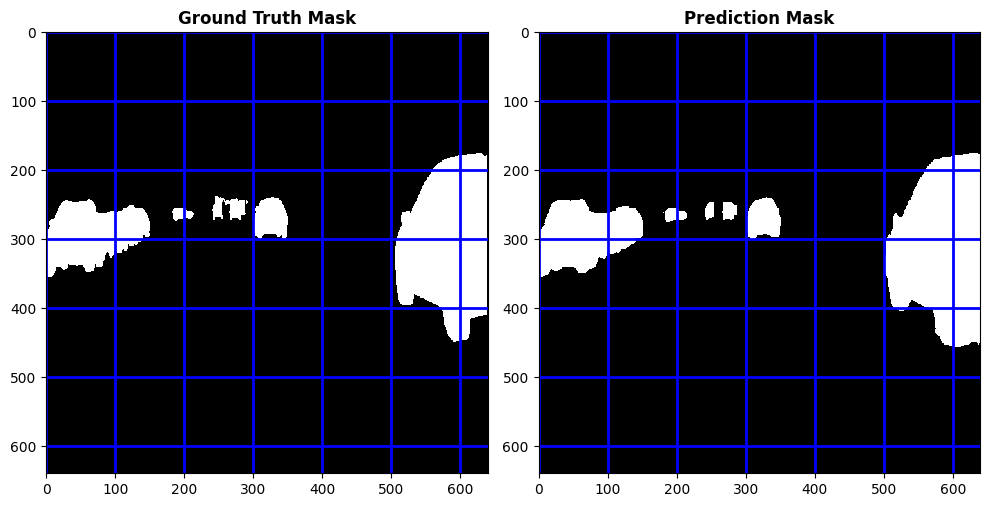

In [ ]:
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000017.png"), mmcv.imread("task/dataset/mean_all_models/000017.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000100.png"), mmcv.imread("task/dataset/mean_all_models/000100.png"))
compare_masks(mmcv.imread("task/dataset/gt_sem_seg/000234.png"), mmcv.imread("task/dataset/mean_all_models/000234.png"))

In [54]:
inputs = [mmcv.imread(file) for file in glob.glob("task/dataset/gt_sem_seg_1/*.png")]
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/mean_all_models/*.png")]

In [55]:
mean_all = metrics_table(inputs, labels)

In [56]:
mean_all.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.911832,0.911343,0.994788,0.906393,0.853651
std,0.139423,0.175232,0.005794,0.160180,0.173153
min,0.000000,0.000000,0.824292,0.000000,0.000000
25%,0.917988,0.923860,0.992898,0.919007,0.850150
50%,0.943842,0.970519,0.995950,0.953841,0.911756
75%,0.958683,0.986929,0.997988,0.969338,0.940501
max,1.000000,0.998654,0.999934,0.989982,0.980162


In [102]:
strange_mean_all = mean_all[mean_all['Precision'] == 0]
print(f'Mean_all_models имеет неадекватные метрики на {strange_mean_all.count()[0]} картинках.')

Mean_all_models имеет неадекватные метрики на 63 картинках.


In [108]:
all_mean_clean = mean_all[mean_all['Dice'] != 0]
all_mean_clean.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3248.000000,3248.000000,3248.000000,3248.000000,3248.000000
mean,0.929518,0.929020,0.994701,0.923974,0.870209
std,0.058061,0.121962,0.005815,0.099530,0.127084
min,0.159320,0.007233,0.824292,0.014311,0.007207
25%,0.920320,0.928301,0.992836,0.921912,0.855137
50%,0.944504,0.971443,0.995850,0.954802,0.913513
75%,0.958884,0.987149,0.997920,0.969549,0.940898
max,1.000000,0.998654,0.999934,0.989982,0.980162


### Посмотрим на другие пороги

In [ ]:
model_list = [psp_model, fcn_model, unet_model, deeplab_model]
ensemble_result_saver(model_list, "mean_all_models_0.1", thr=0.1)

In [58]:
#inputs = [mmcv.imread(file) for file in glob.glob("task/dataset/gt_sem_seg_1/*.png")]
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/mean_all_models_0.1/*.png")]

In [59]:
mean_all_01 = metrics_table(inputs, labels)

In [60]:
mean_all_01.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.779896,0.953733,0.989310,0.847205,0.764657
std,0.193030,0.129247,0.009940,0.176220,0.198276
min,0.000000,0.000000,0.792312,0.000000,0.000000
25%,0.744677,0.969590,0.985830,0.839092,0.722789
50%,0.847803,0.989053,0.991694,0.910949,0.836461
75%,0.901365,0.995491,0.995498,0.943904,0.893768
max,1.000000,1.000000,0.999958,0.982523,0.965646


In [61]:
strange = mean_all[mean_all['Precision'] == 0]
print(f'Mean_all_models_01 имеет неадекватные метрики на {strange.count()[0]} картинках.')

Mean_all_models_01 имеет неадекватные метрики на 63 картинках.


In [ ]:
mean_all_01_clean = mean_all_01[mean_all_01['Dice'] != 0]
mean_all_01_clean.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000
mean,0.786548,0.961867,0.989239,0.854431,0.771179
std,0.179847,0.094979,0.009950,0.158565,0.186059
min,0.003066,0.011062,0.792312,0.005149,0.002581
25%,0.748367,0.970221,0.985732,0.841203,0.725928
50%,0.849292,0.989255,0.991616,0.911451,0.837307
75%,0.901712,0.995511,0.995436,0.944090,0.894100
max,1.000000,1.000000,0.999958,0.982523,0.965646


In [ ]:
model_list = [psp_model, fcn_model, unet_model, deeplab_model]
ensemble_result_saver(model_list, "mean_all_models_0.3", thr=0.3)

In [62]:
inputs = [mmcv.imread(file) for file in glob.glob("task/dataset/gt_sem_seg_1/*.png")]
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/mean_all_models_0.3/*.png")]

In [63]:
mean_all_03 = metrics_table(inputs, labels)

In [64]:
mean_all_03.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.887439,0.933133,0.993952,0.905665,0.848382
std,0.135600,0.154237,0.006650,0.144814,0.160704
min,0.000000,0.000000,0.818831,0.000000,0.000000
25%,0.884245,0.949361,0.991776,0.911988,0.838215
50%,0.923027,0.980804,0.995498,0.947595,0.900410
75%,0.944433,0.991695,0.997776,0.964555,0.931537
max,1.000000,1.000000,0.999934,0.989275,0.978778


In [65]:
strange = mean_all[mean_all['Precision'] == 0]
print(f'Mean_all_models_03 имеет неадекватные метрики на {strange.count()[0]} картинках.')

Mean_all_models_03 имеет неадекватные метрики на 63 картинках.


In [ ]:
mean_all_03_clean = mean_all_03[mean_all_03['Dice'] != 0]
mean_all_03_clean.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000
mean,0.900218,0.946570,0.993876,0.918706,0.860598
std,0.084528,0.106813,0.006667,0.096378,0.125225
min,0.005841,0.033557,0.818831,0.009960,0.005005
25%,0.886028,0.951394,0.991727,0.915088,0.843467
50%,0.923872,0.981195,0.995458,0.948405,0.901873
75%,0.944644,0.991869,0.997689,0.964682,0.931774
max,1.000000,1.000000,0.999934,0.989275,0.978778


Видим, что из перебранных порогов самое высокое качество на целевых метриках показывает порог в 0.5. Дальше будем работать с ним

### Посмотрим на все возможные пары из рассмотренных моделей

In [ ]:
model_names = ["psp", "fcn", "unet", "deeplab"]

combs = list(combinations(model_list, 2))
name_combs = list(combinations(model_names,2))

for comb, name in zip(combs, name_combs):
    op_name = "mean_" + name[0] + "_" + name[1]
    ensemble_result_saver(list(comb), op_name)

In [ ]:
inputs = [mmcv.imread(file) for file in glob.glob("task/dataset/gt_sem_seg_1/*.png")]
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/mean_fcn_deeplab/*.png")]

mean_fcn_deeplab = metrics_table(inputs, labels)

mean_fcn_deeplab.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.913362,0.896968,0.994663,0.899331,0.844189
std,0.145260,0.184153,0.005895,0.167877,0.181533
min,0.000000,0.000000,0.824287,0.000000,0.000000
25%,0.921796,0.905099,0.992839,0.909487,0.834000
50%,0.947540,0.961301,0.995796,0.951791,0.908017
75%,0.961872,0.982194,0.997867,0.968966,0.939801
max,1.000000,0.997872,0.999917,0.990572,0.981321


In [ ]:
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/mean_fcn_unet/*.png")]

mean_fcn_unet = metrics_table(inputs, labels)

mean_fcn_unet.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.918376,0.886542,0.994364,0.896292,0.840302
std,0.150505,0.187668,0.005665,0.171622,0.185327
min,0.000000,0.000000,0.891658,0.000000,0.000000
25%,0.930884,0.890713,0.992489,0.907513,0.830686
50%,0.953162,0.953123,0.995818,0.950479,0.905630
75%,0.965909,0.977552,0.997915,0.967735,0.937487
max,1.000000,0.996917,0.999927,0.991069,0.982297


In [75]:
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/mean_psp_deeplab/*.png")]

mean_psp_deeplab = metrics_table(inputs, labels)

mean_psp_deeplab.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.912049,0.900675,0.994505,0.900656,0.845207
std,0.142078,0.181375,0.006231,0.163417,0.178314
min,0.000000,0.000000,0.820974,0.000000,0.000000
25%,0.920025,0.909607,0.992610,0.910888,0.836359
50%,0.944736,0.964969,0.995781,0.951571,0.907617
75%,0.959544,0.984831,0.997891,0.968552,0.939021
max,1.000000,0.998376,0.999917,0.990529,0.981236


In [ ]:
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/mean_psp_fcn/*.png")]

mean_psp_fcn = metrics_table(inputs, labels)

mean_psp_fcn.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.910930,0.893727,0.994309,0.896204,0.838793
std,0.144138,0.184485,0.006245,0.166808,0.181642
min,0.000000,0.000000,0.822974,0.000000,0.000000
25%,0.919304,0.898278,0.992349,0.905266,0.826927
50%,0.944290,0.959601,0.995601,0.949051,0.903042
75%,0.959268,0.982778,0.997770,0.966995,0.936099
max,1.000000,0.998866,0.999912,0.989929,0.980060


In [ ]:
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/mean_psp_unet/*.png")]

mean_psp_unet = metrics_table(inputs, labels)

mean_psp_unet.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.917104,0.889711,0.994148,0.896981,0.840274
std,0.143822,0.185645,0.006021,0.167303,0.182274
min,0.000000,0.000000,0.890820,0.000000,0.000000
25%,0.927157,0.895395,0.992120,0.907495,0.830655
50%,0.950058,0.956052,0.995789,0.950065,0.904879
75%,0.962836,0.980171,0.997950,0.967205,0.936492
max,1.000000,1.000000,0.999939,0.990178,0.980546


In [ ]:
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/mean_unet_deeplab/*.png")]

mean_unet_deeplab = metrics_table(inputs, labels)

mean_unet_deeplab.describe()

,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.919227,0.892823,0.994486,0.899813,0.845649
std,0.146579,0.186546,0.005819,0.170363,0.183088
min,0.000000,0.000000,0.891404,0.000000,0.000000
25%,0.929299,0.899834,0.992593,0.913208,0.840278
50%,0.952381,0.958579,0.996006,0.952692,0.909657
75%,0.965071,0.980114,0.998010,0.968974,0.939816
max,1.000000,0.998087,0.999939,0.990235,0.980660


Лучше всех в парах показали себя пара PSP и Deeplab. Посчитаем для него метрики без выбросов

In [106]:
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/mean_psp_deeplab/*.png")]

mean_psp_deeplab = metrics_table(inputs, labels)

strange_psp_deeplab = mean_psp_deeplab [mean_psp_deeplab ['Precision'] == 0]
print(f'psp_deeplab имеет неадекватные метрики на {strange_psp_deeplab.count()[0]} картинках.')

mean_psp_deeplab_clean = mean_psp_deeplab[mean_psp_deeplab['Dice'] != 0]
mean_psp_deeplab_clean.describe()

psp_deeplab имеет неадекватные метрики на 65 картинках.


,Precision,Recall,Accuracy,Dice,IoU
count,3246.000000,3246.000000,3246.000000,3246.000000,3246.000000
mean,0.930313,0.918710,0.994411,0.918691,0.862132
std,0.059954,0.130312,0.006256,0.103276,0.133554
min,0.007163,0.011976,0.820974,0.011820,0.005945
25%,0.922107,0.917279,0.992518,0.915817,0.844706
50%,0.945382,0.966277,0.995709,0.952590,0.909472
75%,0.959798,0.985052,0.997816,0.968761,0.939415
max,1.000000,0.998376,0.999907,0.990529,0.981236


### Попробуем взвшенные предсказания - разные модели вносят разные вклады в итоговое предсказание

Веса я выбрал рандомно. По-хорошему можно было бы пройтись грид серчем и подобрать наилучшие веса для такого ансамбля моделей. Но на это у меня, к сожалению, не хватает времени :(

In [37]:
def ensemble_weighted_result_saver(models, ensemble_name, thr = 0.5):
    prefix_path = "task/dataset/" 
    input_path = prefix_path + "imgs/*"
    output_path = prefix_path + ensemble_name + "/"

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    images = glob.glob(input_path)
    predictions = []
    # Random weights
    weights = [0.2, 0.2, 0.2, 0.4]

    for pic in tqdm_notebook.tqdm(images):
        img = mmcv.imread(pic)
        for model in models:
            prediction = inference_model(model, img)
            mask = (prediction.pred_sem_seg.data == 13).type(torch.uint8) 
            predictions.append(mask * 1)
        stack_preds = torch.stack(predictions)
        weighted_preds = torch.Tensor(np.tensordot(stack_preds.cpu(), weights, axes=((0),(0))))
        mean_pred = (torch.mean(weighted_preds, dim=0) > thr) * 1
        predictions = []

        cv2.imwrite(str(output_path+pic[-10:]), mean_pred.numpy())

In [38]:
model_list = [psp_model, fcn_model, unet_model, deeplab_model]
ensemble_weighted_result_saver(model_list, "weighted_all_models")

/tmp/ipykernel_21200/3841077582.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pic in tqdm_notebook(images):


  0%|          | 0/3311 [00:00<?, ?it/s]

In [47]:
inputs = [mmcv.imread(file) for file in glob.glob("task/dataset/gt_sem_seg_1/*.png")]
labels = [mmcv.imread(file) for file in glob.glob("task/dataset/weighted_all_models/*.png")]

weighted_all_models = metrics_table(inputs, labels)

weighted_all_models.describe()


,Precision,Recall,Accuracy,Dice,IoU
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.900435,0.922223,0.994480,0.906582,0.851982
std,0.137972,0.165641,0.006091,0.152835,0.167150
min,0.000000,0.000000,0.820801,0.000000,0.000000
25%,0.901678,0.937655,0.992534,0.916449,0.845783
50%,0.934547,0.975885,0.995774,0.951629,0.907722
75%,0.952576,0.989188,0.997910,0.967767,0.937546
max,1.000000,0.999646,0.999917,0.989790,0.979787


In [111]:
strange_weighted_all_models = weighted_all_models[weighted_all_models['Precision'] == 0]
print(f'weighted_all_models имеет неадекватные метрики на {strange_weighted_all_models.count()[0]} картинках.')

weighted_all_models_clean = weighted_all_models[weighted_all_models['Dice'] != 0]
weighted_all_models_clean.describe()

weighted_all_models имеет неадекватные метрики на 56 картинках.


,Precision,Recall,Accuracy,Dice,IoU
count,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000
mean,0.915926,0.938090,0.994398,0.922179,0.866640
std,0.071907,0.114108,0.006110,0.096813,0.125352
min,0.005841,0.013793,0.820801,0.009960,0.005005
25%,0.904721,0.941762,0.992462,0.918953,0.850058
50%,0.935345,0.976373,0.995681,0.952330,0.908999
75%,0.952737,0.989321,0.997832,0.967903,0.937803
max,1.000000,0.999646,0.999912,0.989790,0.979787


## Выводы и итоги

Создадим два датафрейма с результатами прогонов. Один будет включать выбросы, второй нет. Время инференса, к сожалению, не получится корректно добавить к сравнению, так как одновременно с предсказанием идет чтение-запись картинок.

In [130]:
res_list = [strange_psp.count()[0], strange_unet.count()[0], strange_fcn.count()[0], 
            strange_deeplab.count()[0], strange_mean_all.count()[0], strange_psp_deeplab.count()[0], strange_weighted_all_models.count()[0]]

strange_df = pd.DataFrame(res_list, columns = ["Missed imgs"])
strange_df

,Missed imgs
0,46
1,48
2,48
3,57
4,63
5,65
6,56


In [138]:
res_list = [psp_results.mean(), unet_results.mean(), fcn_results.mean(), 
            deeplab_results.mean(), mean_all.mean(), weighted_all_models.mean(), 
            mean_psp_deeplab.mean()]

names_list = ["PSP", "UNET", "FCN", "Deeplabv3+", "mean_all_models", "mean_psp_deeplab", "weighted_all_models"]
df_names = pd.DataFrame(names_list, columns = ["Model"])

strange_list = [strange_psp.count()[0], strange_unet.count()[0], strange_fcn.count()[0], 
            strange_deeplab.count()[0], strange_mean_all.count()[0], strange_psp_deeplab.count()[0], strange_weighted_all_models.count()[0]]


df = pd.DataFrame(res_list)
result = df_names.join(df)
result["Missed imgs"] = strange_list

result.style.set_properties(subset=['Dice', 'IoU'], **{'background-color': 'blue'})

,Model,Precision,Recall,Accuracy,Dice,IoU,Missed imgs
0,PSP,0.881163,0.917792,0.992891,0.894199,0.831151,46
1,UNET,0.823292,0.913716,0.991577,0.856807,0.783852,48
2,FCN,0.912049,0.900675,0.994505,0.900656,0.845207,48
3,Deeplabv3+,0.894739,0.920317,0.994230,0.902868,0.846170,57
4,mean_all_models,0.911832,0.911343,0.994788,0.906393,0.853651,63
5,mean_psp_deeplab,0.900435,0.922223,0.994480,0.906582,0.851982,65
6,weighted_all_models,0.912049,0.900675,0.994505,0.900656,0.845207,56


In [139]:
res_list = [psp_results_clean.mean(), unet_results_clean.mean(), fcn_results_clean.mean(), 
            deeplab_results_clean.mean(), all_mean_clean.mean(), weighted_all_models_clean.mean(), 
            mean_psp_deeplab_clean.mean()]

df = pd.DataFrame(res_list)

res_list = [strange_psp.count()[0], strange_unet.count()[0], strange_fcn.count()[0], 
            strange_deeplab.count()[0], strange_mean_all.count()[0], strange_psp_deeplab.count()[0], strange_weighted_all_models.count()[0]]

strange_df = pd.DataFrame(res_list, columns = ["Missed imgs"])


result_clean = df_names.join(df)
result_clean = result_clean.join(strange_df)

result_clean.style.set_properties(subset=['Dice', 'IoU'], **{'background-color': 'blue'})

,Model,Precision,Recall,Accuracy,Dice,IoU,Missed imgs
0,PSP,0.893578,0.930722,0.992802,0.906797,0.842861,46
1,UNET,0.835403,0.927158,0.991496,0.869411,0.795383,48
2,FCN,0.930313,0.918710,0.994411,0.918691,0.862132,48
3,Deeplabv3+,0.910412,0.936438,0.994143,0.918683,0.860992,57
4,mean_all_models,0.929518,0.929020,0.994701,0.923974,0.870209,63
5,mean_psp_deeplab,0.915926,0.938090,0.994398,0.922179,0.866640,65
6,weighted_all_models,0.930313,0.918710,0.994411,0.918691,0.862132,56


Как видим из таблички, лучшие результаты по метрике Dice (F1) и лучшее значение IoU показывает усредненное предсказание всех моделей. Конечно, по этим данным нельзя сказать, какой из вариантов объективно лучше для текущей задачи: важны также такие вещи, как количество параметров модели, время обучения, дообучения и инференса, возможности оптимизации. Ансамбли, например, работают в инференсе в несколько раз дольше, чем модели по отдельности, т.к. для каждого объекта предсказание должны сделать все модели, включенные в ансамбль. На решение о выборе того или иного варианта может также влиять железо, на котором планируется выкатка итогового решения. В общем, все довольно ситуативно.

На этом анализ, на который у меня хватило сил и времени, подходит к концу. Хотелось бы многое еще попробовать в рамках этого задания. Например, посмотреть на маленькие сетки, вроде MobileNet, сравнить результаты всех рассмотренных моделей и ансамблей после файн тюнинга на текущем датасете. Очень интересно попробовать сделать бэггинг и бустинг на каких-то очень простых нейросетях - не ожидаю чуда в плане качества, нигде не встречал такого подхода (наверное плохо искал), но любопытно.  